# Performing an error mitigation workflow with program sets on Amazon Braket

This notebook builds on topics present in the error mitigation workflow seen using mitiq, but instead focuses on a QHP-based (Rigetti) workflow. As such, it requires substantial customization beyond what is commonly available. 
>[!WARNING]
>Executing this notebook with devices will charge your AWS account! Please keep this in mind and verify with the previous notebook tracker. 

### Overview of device-orientied error mitigated workflow

We forgoe using mitiq, namely because most of the features which do helpful things like modify circuits are not specific enough for our purposes, and are not currently implemented or supported in mitiq. 

However, we can use the general workflow, i.e. ZNE + twirl + REM. This is common enough in the literature. 

To submit things a device, we still need a few adjustments to our workflow. In particular we have a few additions to optiimze performance and minimize cost: 

- Update shot allocation:
    - For observables 
    - For the exponential regression 
- Perform compilation to native gates and an optimized layout 
- Twirl with native gates (ISwap for Rigetti)
- Utilize a scalable REM procedure (i.e. we use a sparse REM)
- Tighten overheads

Let's start by gathering (all) of our imports. 

In [ ]:
import os
import sys

import numpy as np

from braket.circuits import Circuit
from braket.tracking import Tracker

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent  

from warnings import filterwarnings

import matplotlib.cm as cm

# need these for later
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_braket_provider import to_braket
from tools.circuit_tools import (
    convert_paulis,
    fidelity_estimation,
    find_linear_chain,
    multiply_gates,
    restricted_circuit_layout,
    strip_verbatim,
)
from tools.mitigation_tools import (
    SparseReadoutMitigation,
    apply_readout_twirl,
    generate_bit_mask,
    get_twirled_readout_dist,
    twirl_iswap,
)
from tools.observable_tools import pauli_grouping
from tools.program_set_tools import ANKAA_CONVERSION, run_with_program_sets
from tools.stat_tools import jackknife_bias_corrected, perform_regression

from braket.aws import AwsDevice
from braket.devices import Devices

filterwarnings("ignore",category=UserWarning, module="qiskit_braket_provider")
np.set_printoptions(precision=3, linewidth=500, suppress=True)

ankaa = AwsDevice(Devices.Rigetti.Ankaa3)
props = ankaa.properties.standardized
# emulator = ankaa.emulator() # optional for verifying 
print('loaded Ankaa-3 device')
tracker = Tracker()
tracker.start()


loaded Ankaa-3 device and backend


>[!NOTE]
> To use the emulator, you can simply specify a smaller number of qubits, and modify the device target 

Now we define our problem Hamiltonian, here a simple Ising Hamiltonian. For simplicity, we use a simple string representation of the Pauli operators, and a greedy color-based grouping scheme using networkx. 

Unlike the previous approach, here we will push our system size, using 10 qubits for the emulator, but up to 30 on the device. 

In [2]:
def ising_hamiltonian(
        interaction : float, 
        transverse_field : float, 
        num_qubits : int):
    hamiltonian = []
    n = num_qubits
    for i in range(num_qubits):
        hamiltonian.append(
            (transverse_field,i*"I"+"X"+(n-i-1)*"I")
            )
        if i>0:
            hamiltonian.append(
                (interaction, (i-1)*"I"+"ZZ"+(n-i-1)*"I"))
    return hamiltonian


interaction = 0.1
transverse_field = -0.02
num_qubits = 30

ham = ising_hamiltonian(interaction, transverse_field, num_qubits = num_qubits)

bases, pauli_terms = pauli_grouping(ham)
# print(bases)
print(f'number of distinct measurement bases: {len(bases)}') 
print(bases)
print(pauli_terms)


number of distinct measurement bases: 2
['XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ']
[[(-0.02, 'IXIIIIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIXIIIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIXIIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIXIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIXIIIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIXIIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIXIIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIXIIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIXIIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIXIIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIXIIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIXIIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIXIIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIXIIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIXIIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIIXIIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIIIXIIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIIIIXIIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIIIIIXIIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIIIIIIXIIIIIIIII'), (-0.02, 'IIIIIIIIIIIIIIIIIIII

In [ ]:
## UNCOMMENT_TO_RUN
# num_qubits = 5
# ham = ising_hamiltonian(interaction, transverse_field, num_qubits = num_qubits)
# bases, pauli_terms = pauli_grouping(ham)

### Step 0.0 - Shot allocation

Now, we can further consider the L1 norm of the total coefficients. That is, let $\alpha$ denote a base, and $c_i^\alpha$ a term $i$ within the base, we can then calculate the $l_1$ norm for each base:

In [3]:
norms = np.array([sum([abs(p[0]) for p in items]) for items in pauli_terms])
print('Norms per measurement basis: ',norms)

interaction = interaction / np.sum(norms)
transverse_field = transverse_field / np.sum(norms) 

ham = ising_hamiltonian(interaction, transverse_field,num_qubits = num_qubits)

bases, pauli_terms = pauli_grouping(ham)
# print(bases)
print(f'number of distinct measurement bases: {len(bases)}') 
print(bases)
print(pauli_terms)
norms = np.array([sum([abs(p[0]) for p in items]) for items in pauli_terms])
print('Renormalized norms: ',norms)

Norms per measurement basis:  [0.6 2.9]
number of distinct measurement bases: 2
['XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ']
[[(-0.005714285714285713, 'IXIIIIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIXIIIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIXIIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIXIIIIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIXIIIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIXIIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIXIIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIXIIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIIXIIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIIIXIIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIIIIXIIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIIIIIXIIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIIIIIIXIIIIIIIIIIIIIIII'), (-0.005714285714285713, 'IIIIIIIIIIIIIIXIIIIIIIIIIIIIII'), (-0.005714285714285713,

We then use code from a previous notebook on ProgramSets: 

In [4]:
def allocate_by_weight(
    target_weights: list[int | float], 
    total_allocation: int, 
    min_allocation: int = 1
) -> list[int]:
    """
    Allocate items by weight with minimum allocation constraints.
    
    Args:
        target_weights: List of target weights
        total_allocation: Total number of items to allocate
        min_allocation: Minimum allocation per bin
        
    Returns:
        List of allocated counts per bin, approximating the provided target weight.
    """
    size = len(target_weights)
    
    assert (min_allocation*size <= total_allocation), \
         f"Can't allocate {total_allocation} items across {size} bins with at least {min_allocation} items per bin"

    allocation = [min_allocation] * size # Secure the required minimum allocation first
    for i in range(total_allocation - min_allocation*size):
        idx = max(range(size), key = lambda j: abs(target_weights[j]) / (max(allocation[j],1)))
        allocation[idx] += 1

    return allocation

Text(0, 0.5, 'Distance from target distribution')

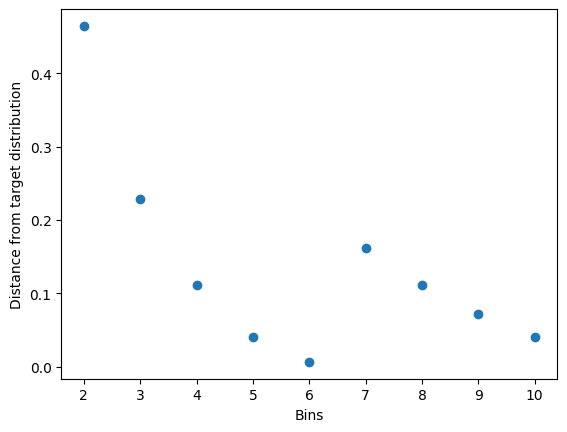

In [5]:
residuals = []
for total_terms in range(2,11):
    res = np.array(allocate_by_weight(target_weights= norms / np.sum(norms), 
                             total_allocation=total_terms, min_allocation=1))
    residuals.append(np.linalg.norm(norms / np.sum(norms) - res / np.sum(res)))
plt.scatter(range(2,11), residuals)
plt.xlabel("Bins")
plt.ylabel("Distance from target distribution")
    

Generally, our variance can be calculated as:

$ {\rm Var}[O] = \sum \frac{|c_i|^2}{M_j}$ 
where $c_i$ is the coefficient and $M_j$ is the number of shots. Let $p$ denote the fraction of circuits allocated for the $X_i$ observables, then we have that $M = M_z + M_x = (1-p_z) M + p M$. The variance expression is then:

$ {\rm Var}[O] \approx N_q \frac{|U|^2}{p M} + (N_q-1) \frac{|V|^2}{(1-p)M } = \frac{N_q}{M}(\frac{|U|^2}{p} + \frac{N_q -1}{N_q}\frac{|V|^2}{(1-p)})$ 

Better shot allocation strategies usually take preliminary estimations of the observable value into consideration as well, though here we average over all possible states. 

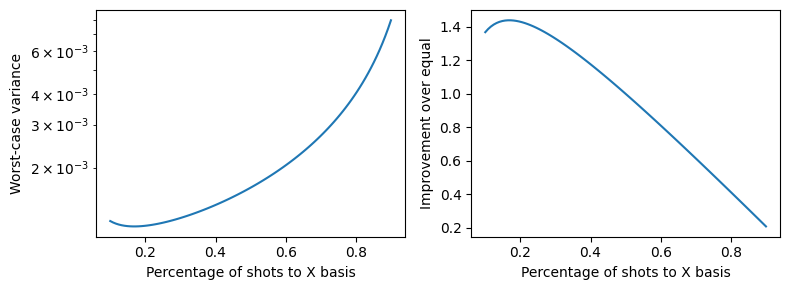

In [6]:
def worst_case(p, num_qubits):
    return (transverse_field)**2/p + (interaction)**2 * (num_qubits - 1)/num_qubits / (1-p)

xs = np.linspace(0.1, 0.9, 100)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(xs,worst_case(xs, 40),)
ax[0].set_xlabel("Percentage of shots to X basis")
ax[1].set_xlabel("Percentage of shots to X basis")
ax[0].set_ylabel("Worst-case variance")
ax[1].set_ylabel("Improvement over equal")
ax[0].set_yscale('log')
ax[1].plot(xs, worst_case(0.5, 40) /  worst_case(xs, 40) ,label="Improvement")
plt.tight_layout()
plt.show()

In [7]:
multiplicity = [1,4] # balance of optimal and efficient     

bases_expanded = [bases[0]] * multiplicity[0] + [bases[1]] * multiplicity[1]
paulis_expanded = []
for reps, items in zip(multiplicity, pauli_terms):
    paulis_expanded.extend([(c/reps,p) for c,p in items] for _ in range(reps))


### Step 0.1 - Preparing a native circuit

Here, we use a simple layer / brick circuit, simplifying from previous work. The main goal of this experiment will be to mitigate a known reference, i.e. either $|\vec{0}\rangle$ or $|\vec{1}\rangle$. We do this by generating a circuit that we know is essentially the identity, and seeing to what extent we can reproduce it. 

In [8]:
def test_circuit(
        num_qubits : int):
    """ this is a odd, but functional circuit, which is the same under gate folding """
    circ = Circuit()
    for i in range(0,num_qubits-1,2):
        circ.iswap(i,i+1)
        circ.rz(i  ,np.pi/2)
        circ.rz(i+1,np.pi/2)
    for i in range(1,num_qubits-1,2):
        circ.iswap(i,i+1)
        circ.rz(i  ,np.pi/2)
        circ.rz(i+1,np.pi/2)
    return circ

ansatz_v0 = test_circuit(num_qubits=num_qubits)


Now, we will somewhat modify our transpilation procedure, using some prebuilt functionality in `tools/circuit_tools.py`. First, we will explicitly remove "bad" connections, i.e. gates with a infidelity above a certain threshold. These are penalized by both the Qiskit transpiler and the Braket compiler, but we want to explicitly remove these. 

In [55]:
ansatz_v1 = restricted_circuit_layout(ansatz_v0, ankaa)
chain = find_linear_chain(ansatz_v1)
starting_condition = Circuit()
for n,qubit in enumerate(chain):
    starting_condition.rx(qubit, np.pi) # start in the all ones state
ansatz_v1 = starting_condition + ansatz_v1
print(ansatz_v1)
print(chain)

= limit(2q): 0.05
= limit(ro): 0.125
= limit(1q): 0.025
 - num steps: 32
 - steps: [2.44140625e-05, 6.103515625e-05, 2.44140625e-05]
T   : │     0      │        1        │              2              │     3      │              4              │     5      │       6       │
       ┌──────────┐                   ┌───────┐                     ┌──────────┐                                                            
q1  : ─┤ Rx(3.14) ├───StartVerbatim───┤ ISWAP ├─────────────────────┤ Rz(1.57) ├──────────────────────────────────────────────EndVerbatim───
       └──────────┘         ║         └───┬───┘                     └──────────┘                                                   ║        
       ┌──────────┐         ║         ┌───┴───┐                     ┌──────────┐ ┌───────┐                     ┌──────────┐        ║        
q8  : ─┤ Rx(3.14) ├─────────║─────────┤ ISWAP ├─────────────────────┤ Rz(1.57) ├─┤ ISWAP ├─────────────────────┤ Rz(1.57) ├────────║────────
       └──────────┘  

We can visualize this below: 

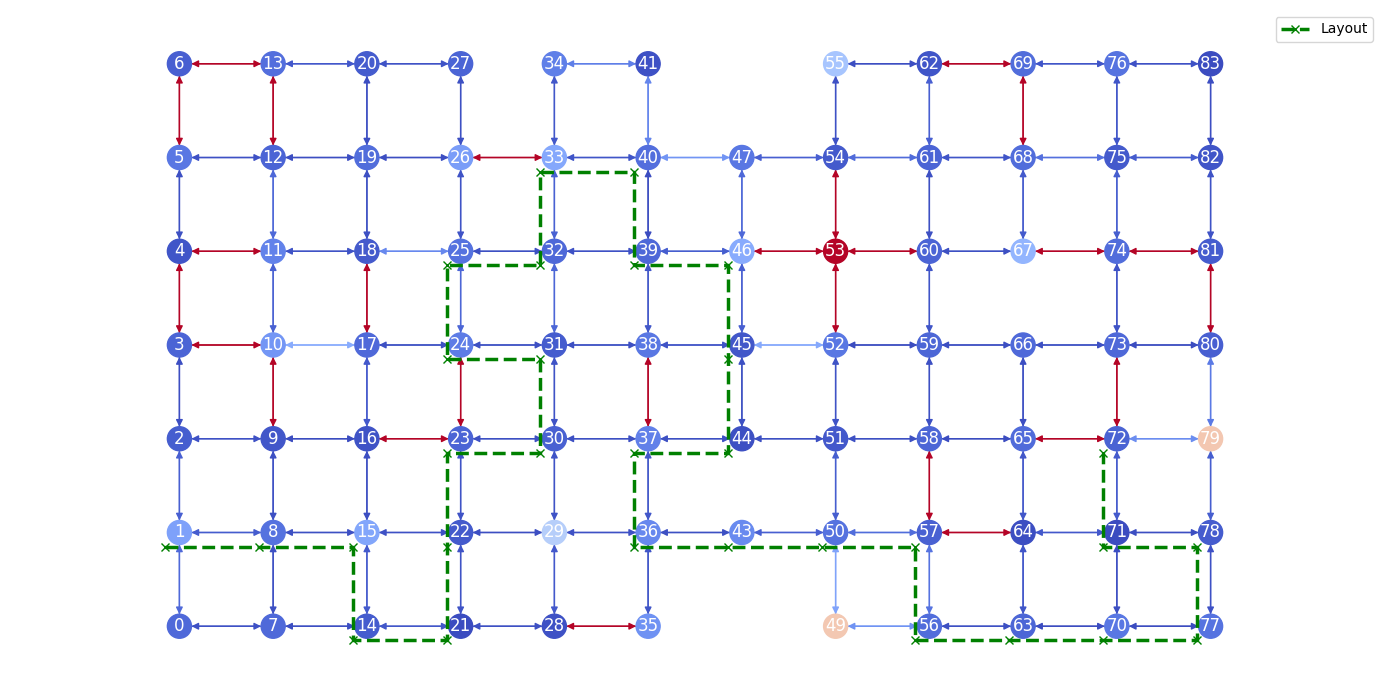

In [10]:

ankaa_grid = [
    [0,7,14,21,28,35,None,49,56,63,70,77],
    [1,8,15,22,29,36,43,50,57,64,71,78],
    [2,9,16,23,30,37,44,51,58,65,72,79],
    [3,10,17,24,31,38,45,52,59,66,73,80],
    [4,11,18,25,32,39,46,53,60,67,74,81],
    [5,12,19,26,33,40,47,54,61,68,75,82],
    [6,13,20,27,34,41,None,55,62,69,76,83]
]

ankaa_pos = {q:(j,i) for i,row in enumerate(ankaa_grid) for j, q in enumerate(row)}
ankaa_pos_under = {q:(j+0.05,i+0.05) for i,row in enumerate(ankaa_grid) for j, q in enumerate(row)}


props_std = ankaa.properties.standardized.dict()
graph_nodes, graph_edges =list(ankaa.topology_graph.nodes()), list(ankaa.topology_graph.edges())

node_vals = [1 - props_std['oneQubitProperties'][str(node)]['oneQubitFidelity'][2]['fidelity'] for node in graph_nodes]

edge_vals = []
for edge in graph_edges:
    if edge[0] > edge[1]:
        edge = (edge[1], edge[0])
    edge_key = f"{edge[0]}-{edge[1]}"
    fidelity = 1 - props_std['twoQubitProperties'][edge_key]['twoQubitGateFidelity'][0]['fidelity']
    edge_vals.append(fidelity)

fig, ax = plt.subplots(figsize=(14,7))
nx.draw(ankaa.topology_graph, 
        ankaa_pos, 
        node_color=node_vals, 
        edge_color=edge_vals, 
        cmap=cm.coolwarm, 
        edge_cmap=cm.coolwarm, 
        with_labels=True,
        font_color = 'w',
        ax=ax)

traj = [int(k) for k in chain]
traj_x = [ankaa_pos[p][0]-0.15 for p in traj]
traj_y = [ankaa_pos[p][1]-0.15  for p in traj]
plt.plot(traj_x, traj_y, 'g', marker='x' , linewidth=2.5, linestyle='--', label='Layout')
plt.legend()
plt.axis('equal')

plt.tight_layout()

plt.show()


### Step 0.2 - Estimating REM Overhead

Based on our qubit layout, we can evaluate what we expect our 2-qubit REM overhead to be:

In [54]:
readout_errors = []
for qubit, vals in props.oneQubitProperties.items():
    if int(qubit) not in ansatz_v1.qubits:
        continue
    for item in vals.oneQubitFidelity:
        temp = item.dict()
        if temp['fidelityType']['name'] == "READOUT":
            readout_errors.append(1-temp['fidelity'])

ro_sorted = sorted(readout_errors,reverse=True)
print(ro_sorted)

[0.08999999999999997, 0.08699999999999997, 0.08499999999999996, 0.07999999999999996, 0.05900000000000005, 0.05700000000000005, 0.050000000000000044, 0.04600000000000004, 0.04300000000000004, 0.040000000000000036, 0.039000000000000035, 0.038000000000000034, 0.038000000000000034, 0.03600000000000003, 0.03500000000000003, 0.030000000000000027, 0.030000000000000027, 0.029000000000000026, 0.027000000000000024, 0.026000000000000023, 0.025000000000000022, 0.025000000000000022, 0.02100000000000002, 0.02100000000000002, 0.02100000000000002, 0.020000000000000018, 0.017000000000000015, 0.01100000000000001, 0.008000000000000007, 0.008000000000000007]


Assuming we only need two-local qubits, then we find our worst-case and average overheads: 

In [12]:
gamma = (1/(1-2*ro_sorted[0])/(1-2*ro_sorted[1]))**2
print(f'Worst-case gamma: {gamma}')
print(f'Average gamma: {(1/(1-np.mean(ro_sorted)))**4}')

Worst-case gamma: 2.1797776765578147
Average gamma: 1.1679388436521678


### Step 0.3 - Modeling Extrapolation Errors 

Finally, we perform a very coarse estimate of the extrapolation. We will look at the decay probability of an observable based on the number of two-qubit gates it touches through a lightcone depiction. 

From that, we will see how we expect our variance to increase based on our exponential regression. 

In [13]:
predicted_fidelity, ins = fidelity_estimation(ansatz_v1, ankaa, "ISwap")
print(f"Predicted active volume fidelity: {predicted_fidelity}")
print(f'Naive percent of ISwaps in the light cone: {ins[0]}/{ins[1]}')


Predicted active volume fidelity: 0.9537752778786989
Naive percent of ISwaps in the light cone: 4/29


Recalling that for exponential regression, our weights are proportional to the variance 

Naively, we should have that $w_i \propto \frac{1}{\sigma^2} \approx y_i^2 $. This indicates that the variance  $\sigma^2 \propto \frac{1}{y_i^2}$. Practically these are weighted as $\frac{1}{|y_i|}$. 

In [14]:
print('predicted fidelities: ')

exps = [1, 3, 5]
var_increase = [predicted_fidelity**2/predicted_fidelity**(2*n) for n in exps]
exp_fid = [predicted_fidelity**(n) for n in exps]
print('expected increase in variance: ')
print(var_increase)
print('expected fidelities')
print(exp_fid)

predicted fidelities: 
expected increase in variance: 
[1.0, 1.2084140195924673, 1.460264442747624]
expected fidelities
[0.9537752778786989, 0.8676372389252922, 0.7892785605055754]


In [15]:
scale_factors  = exps
scale_factor_multiplicity = [1,1,2] # set manually
scale_factors_expanded = [s for s, m in zip(scale_factors, scale_factor_multiplicity) for _ in range(m)]
print(f'expanded scale factors: {scale_factors_expanded}')

expanded scale factors: [1, 3, 5, 5]


Thus, we should increase the variance of our extrapolated points, as the distribution will be heteroskedastic after the log transform. 

### Step 0.4 - Set Cost and Resources

Here we define our parameters for our system and subsequent error mitigation. We being with the norm of the Hamiltonian, which here we have normalized to unity. Generally this will increase our variance quadratically. The estimated number of circuits will be naively $N_{ZNE} * N_{para} * N_{twirls} * N_{bases} + N_{REM}$. Explicitly, this is `len(scale_factors) * num_twirls * len(parameters) * len(bases) + rem_twirls`. 

`shot_per_base` here refers to each function evaluation, and naively is distributed according to each observable basis. Overhead is actually that, the multiplicative factor that we will increase by. It can match the REM overhead or potentially exceed it, though there are limits to which we trust the reliability of it.  

In [16]:
from math import ceil

precision = 1/np.sqrt(900)
print(f'Precision: {precision}')
L = np.sum(norms) # set to 1
print(f'Normalization (should be unity): {L}')
assert abs(L-1)<1e-8
shots_per_obs = ceil(1/precision**2)
print(f'Total shots per observable: {shots_per_obs}')


Precision: 0.03333333333333333
Normalization (should be unity): 1.0000000000000002
Total shots per observable: 900


To determine our shots, we deal with a number of factors. Roughly speaking, our overhead is the factor above our base precision, or shots per observable. For our mitigation and REM learning, it is the REM overhead times an arbitrary overhead factor.

Given that our observable is split into a product of bases and twirls, this defines our bases number of executables. For instance, with 25 twirls and 6 bases, and 1 `shot_per_executable`, we will still have 150 shots. If our precision requires 400, we need 3 `shots_per_executable` to reach our target precision, i.e. 450 shots. If our overhead was 2, then we would need at least 800 shots total, which is 6 `shots_per_executable` (900 total). 

In [17]:
from math import ceil

n_bases = len(bases_expanded)
rem_overhead = gamma # infer based on reported gamma 
overhead = 1
rem_twirls = 100
num_twirls = 16

exec_per_ev = n_bases * num_twirls
parameters = [{}]
shots_per_ev =  ceil(shots_per_obs *rem_overhead * overhead / exec_per_ev) * exec_per_ev
mitigation_shots = shots_per_ev * len(scale_factors_expanded) * len(parameters)
shots_per_exec = shots_per_ev // exec_per_ev
assert shots_per_exec >= 10, f"proposed shots per executable: {shots_per_exec}, needs to be larger than 10"
print('   --- MITIGATION --- ')
print(f'** given {n_bases} bases and {num_twirls} twirls, we have {exec_per_ev} executables')
print(f'** given an overhead of {overhead:.2f}*{rem_overhead:.2f}={overhead*rem_overhead:.2f}')
print(f'**   and an expected precision of {precision} with {shots_per_obs} shots,')
print(f'**   the number of shots we need to estimate <O> is {shots_per_ev}, i.e. {shots_per_exec} shots per executable')
print(f'** we also expect {len(scale_factors_expanded)*len(parameters)} expectations, yielding a total shots of: {mitigation_shots}')
mitigation_circuits = len(scale_factors_expanded) * num_twirls * len(parameters) * n_bases 
readout_circuits = rem_twirls
print(f'**   this is possible in {mitigation_circuits} circuits \n')

shots_per_ro = ceil(shots_per_ev / readout_circuits ) 
readout_shots = shots_per_ro * rem_twirls

print('  --- READOUT  --- ')
print(f'** given {rem_twirls} twirls == circuits, and {shots_per_ev} shots per expectation')
print(f'**   we have {shots_per_ro} shots per ro, i.e. {readout_shots} shots total')


print('\n  --- STATISTICS ---')
print(f'** total number of shots: {readout_shots + mitigation_shots}')
print(f"** total number of circuits: {readout_circuits + mitigation_circuits}")
print(f'** shot overhead: {(readout_shots + mitigation_shots)/shots_per_obs:.2f}x')

print('\n  --- COST --- ')
num_ps= ceil(mitigation_circuits / 100) + ceil(readout_circuits / 100)
task_cost = 0.3 * num_ps
shot_cost_ankaa = (readout_shots + mitigation_shots)*0.0009
task_cost_extra = 0.3 * (2 * num_ps - ceil(readout_circuits / 100))
shot_cost_extra = (readout_shots + 2*mitigation_shots)*0.0009
print(f'** task cost: ${task_cost:0.2f}, reduced from ${(mitigation_circuits + readout_circuits)*0.3}')
print(f'** shots cost (ankaa): ${shot_cost_ankaa:.2f}, ro/mit:${0.0009*readout_shots:.2f}/${mitigation_shots*0.0009 :.2f}')
print(f'** total cost: ${task_cost + shot_cost_ankaa:.2f} ')
print(f'** total cost (+extra): ${task_cost_extra + shot_cost_extra:.2f} ')

   --- MITIGATION --- 
** given 5 bases and 16 twirls, we have 80 executables
** given an overhead of 1.00*2.18=2.18
**   and an expected precision of 0.03333333333333333 with 900 shots,
**   the number of shots we need to estimate <O> is 2000, i.e. 25 shots per executable
** we also expect 4 expectations, yielding a total shots of: 8000
**   this is possible in 320 circuits 

  --- READOUT  --- 
** given 100 twirls == circuits, and 2000 shots per expectation
**   we have 20 shots per ro, i.e. 2000 shots total

  --- STATISTICS ---
** total number of shots: 10000
** total number of circuits: 420
** shot overhead: 11.11x

  --- COST --- 
** task cost: $1.50, reduced from $126.0
** shots cost (ankaa): $9.00, ro/mit:$1.80/$7.20
** total cost: $10.50 
** total cost (+extra): $18.90 


### Step 0.5 - Generating Circuits

In [18]:
folded_circuits = [multiply_gates(ansatz_v1, ['ISwap','Rz'],scale) for scale in scale_factors_expanded]


circuits_pre = np.array([twirl_iswap(c, num_twirls) for c in folded_circuits], dtype=object)


circuits, twirls =  apply_readout_twirl(circuits_pre)

circuits = np.vectorize(convert_paulis)(circuits)
circuits = np.vectorize(strip_verbatim)(circuits)
print('circuits shape: ',circuits.shape)
print('twirls shape: ', twirls.shape)
assert circuits.shape == twirls.shape
# output is (ZNE, twirls)

def count_iswap(circ : Circuit):
    count = 0
    for instruction in circ.instructions:
        if instruction.operator.name == "ISwap":
            count += 1
    return count

print('Number of 2Q gates in each folded circuit:')
for f in folded_circuits:
    print(count_iswap(f), 'ISwap gates')

circuits shape:  (4, 16)
twirls shape:  (4, 16)
Number of 2Q gates in each folded circuit:
29 ISwap gates
87 ISwap gates
145 ISwap gates
145 ISwap gates


We can also just visually verify that our circuits look reasonable:

And finally create the corresponding readout error masks to modify the distributions. 

In [19]:
bit_masks = generate_bit_mask(twirls, bases_expanded)

### Error Mitigation Workflow

#### Step 1 - Readout Calibration

`get_twirled_readout_dist` will perform the REM technique described previously, and return the bit flip distribution. From that, we can construct a single-qubit RO errors. Unlike previously, we will vary our implementation slightly. 

Instead of using a measurement filter, we will return **all** dictionary outputs, and then post-process them. This is namely because the measurement mitigation approach of mitiq is not scalable for very large numbers of qubits. 

For each measurement result, we will evaluate the readout correction over a sparse set of observables. This lowers the effective variance overhead of mitigating the entire distribution substantially. 

In [20]:
def processing_function(circ : Circuit) -> Circuit:
    """ post-processing for the relevant circuits to native verbatim"""
    temp =  to_braket(circ, braket_device = ankaa, add_measurements=False, optimization_level=0)
    temp = Circuit().add_circuit(temp, target_mapping = {i: v for i,v in enumerate(sorted(ansatz_v1.qubits))})
    return temp

# obtain readout distribution 
dist = get_twirled_readout_dist(
    range(num_qubits),
    rem_twirls, 
    shots = int(readout_shots), 
    device = ankaa, 
    processor = processing_function)




BASE:  {'000000001011000000000000000000': 0.0005, '000001000000100000000000000000': 0.0015, '000000001001000000000000000000': 0.0045, '000000000000000000000100000000': 0.007, '000000001000001000000000110000': 0.0005, '100000001001100010000000000000': 0.0005, '000000000001100101000010001000': 0.0005, '000000000000000000000000000000': 0.0955, '000000000000100000000000000000': 0.017, '000000000001000001000000000000': 0.0015, '000000001001010000000111000000': 0.0005, '000000000010100000000000000000': 0.002, '000100000110010000000000000000': 0.0005, '000000001001000000010000000000': 0.001, '000000000000100100000000111001': 0.0005, '000000001001000000000010010000': 0.0005, '001000000000000000000011000000': 0.0005, '000100000000000000100000000000': 0.0005, '100000001001000000000000000000': 0.001, '000000000000001100000010000100': 0.0005, '100000100000000000000000000000': 0.0025, '000000000000000000000000000010': 0.0075, '000000000100010000000000000000': 0.0005, '000100001000001000000000100000

#### Step 2.0 - Main Execution

Now, we begin our main execution. Supplying `None` as our set of observables indicates that we want to return the output distribution. 

In [21]:
result, psets = run_with_program_sets(
    circuits, bases_expanded, [None]*n_bases, parameters = [{}], device = ankaa,
    shots_per_executable = shots_per_exec,
    conversion=ANKAA_CONVERSION,
    return_program_sets = True,
    verbatim=True)

# the output of test is a dim_circ + dim_para + dim_bases, 
# which is (N_zne, N_twirl), (N_para=1,) and (N_bases,) respectively
print(result.shape)

-- 320 tasks required: splitting up into multiple program sets. 
running program sets....
-- running program set 1/4
-- running program set 2/4
-- running program set 3/4
-- running program set 4/4
(4, 16, 1, 5)


### Step 3.0 - processing our results

Now, we need to carry out our processing. The main two ways are to extrapolate a final expectation value, or to extrapolate each Pauli observable, and then sum. We find the latter method typically works slightly better, but that may not be true for all systems. 

Additionally, we have three relevant set of qubit labels to keep track of. First, our problem and associated Hamiltonian entries, which are indexed from 1 to `num_qubits`. These are associated with a physical set of qubits, and finally there is the register, which importantly, is taken to be ordered by design. 

In [22]:
physical = sorted(ansatz_v1.qubits)
prob_to_phys = {n:int(k) for n,k in enumerate(chain)} 
phys_to_reg = {int(k):n for n,k in enumerate(physical)}

def remap(pstr : str) -> str:
    """ given problem Pauli, return the Paul observable over the register"""
    temp = [None]*len(pstr)
    for n,p in enumerate(pstr):
        index = phys_to_reg[prob_to_phys[n]]
        temp[index] = p
    return "".join(temp)

print('problem -> register')
for i in range(num_qubits-1):
    print(paulis_expanded[1][i][1],'->',remap(paulis_expanded[1][i][1]))


problem -> register
ZZIIIIIIIIIIIIIIIIIIIIIIIIIIII -> ZZIIIIIIIIIIIIIIIIIIIIIIIIIIII
IZZIIIIIIIIIIIIIIIIIIIIIIIIIII -> IZIZIIIIIIIIIIIIIIIIIIIIIIIIII
IIZZIIIIIIIIIIIIIIIIIIIIIIIIII -> IIZZIIIIIIIIIIIIIIIIIIIIIIIIII
IIIZZIIIIIIIIIIIIIIIIIIIIIIIII -> IIZIZIIIIIIIIIIIIIIIIIIIIIIIII
IIIIZZIIIIIIIIIIIIIIIIIIIIIIII -> IIIIZZIIIIIIIIIIIIIIIIIIIIIIII
IIIIIZZIIIIIIIIIIIIIIIIIIIIIII -> IIIIIZZIIIIIIIIIIIIIIIIIIIIIII
IIIIIIZZIIIIIIIIIIIIIIIIIIIIII -> IIIIIIZIIZIIIIIIIIIIIIIIIIIIII
IIIIIIIZZIIIIIIIIIIIIIIIIIIIII -> IIIIIIIIIZZIIIIIIIIIIIIIIIIIII
IIIIIIIIZZIIIIIIIIIIIIIIIIIIII -> IIIIIIIZIIZIIIIIIIIIIIIIIIIIII
IIIIIIIIIZZIIIIIIIIIIIIIIIIIII -> IIIIIIIZZIIIIIIIIIIIIIIIIIIIII
IIIIIIIIIIZZIIIIIIIIIIIIIIIIII -> IIIIIIIIZIIZIIIIIIIIIIIIIIIIII
IIIIIIIIIIIZZIIIIIIIIIIIIIIIII -> IIIIIIIIIIIZZIIIIIIIIIIIIIIIII
IIIIIIIIIIIIZZIIIIIIIIIIIIIIII -> IIIIIIIIIIIIZIIIZIIIIIIIIIIIII
IIIIIIIIIIIIIZZIIIIIIIIIIIIIII -> IIIIIIIIIIIIIIIZZIIIIIIIIIIIII
IIIIIIIIIIIIIIZZIIIIIIIIIIIIII -> IIIIIIIIIIIIIIIZIIIIZIIIIIIIII
IIIII

Now, we calculate an "observable" array, which is expanded over to include the particular Pauli observables for each basis. Thus it has naively one more dimension, before being traced over. 

However, we can see that this basis has some redundant elements, namely in axis 0 (scale factors) and 3 (bases). 

In [23]:
rem_mitigation = SparseReadoutMitigation(dist)

len_paulis = max([len(p) for p in pauli_terms])
obs = np.zeros(result.shape + (len_paulis,))
for n,(ind,data) in enumerate(np.ndenumerate(result)):
    paulis = paulis_expanded[ind[-1]]
    for m,(coeff, pauli) in enumerate(paulis):
        obs[ind+ (m,)]+= rem_mitigation.process_single(data, n, remap(pauli), bit_masks=bit_masks)
    
print(obs.shape)
print(bases_expanded)
print(scale_factors_expanded)

(4, 16, 1, 5, 30)
['XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ']
[1, 3, 5, 5]


Now, let's average over these:

In [24]:

cobs = np.concatenate([obs[:2],obs[2:].mean(axis=0, keepdims=True)])
cobs = np.concatenate([cobs[:,:,:,:1,:],cobs[:,:,:,1:,:].mean(axis=3, keepdims=True)],axis=3)
print('Contracted observable shapes: ')
print(cobs.shape)
coeff_mat = np.zeros((len(bases),len_paulis))

for i,c in enumerate(pauli_terms):
    for j,d in enumerate(c):
        coeff_mat[i,j] = d[0] 

Contracted observable shapes: 
(3, 16, 1, 2, 30)


We will complete our estimates by using a jackknife estimate of zero-noise extrapolate. This will be with respect to the twirls, i.e. we will omit a single twirl and then calculate the mean estimate. 

The `zne_processor` function takes care of applying the regression to the appropriate set of data. More details on these tools can be seen in the `tools/stat_tools.py` folder, but the general idea follows a logarithmic regression with the delta approximation for the variances. We also do some basic truncations based on known properties of expectation values. 

In [ ]:
print('Performing jackknife resampling to calculate extrapolation coefficients...')

def zne_processor(data : np.ndarray) -> float:
    """ perform ZNE over each Pauli observable, and then sum"""
    temp = np.copy(data)
    temp = np.sum(temp,axis=2) # sum over 1-d parameter axis
    temp = np.average(temp, axis=1) # average over twirls 
    temp[np.abs(temp)<1e-8] = 1e-8 # set non-zero threshold for log 
    zne_vals = np.zeros(temp.shape[1:]) # (bases x observables)
    for n, _ in np.ndenumerate(zne_vals):
        dat = temp[:,n[0],n[1]]
        var = np.ones(len(dat))/(shots_per_ev) # delta approximation
        var[-1] *= 1/2
        if np.sum(np.abs(dat)) <1e-3:
            zne_vals[n] =  0
        else:
            zne_vals[n] = perform_regression(scale_factors, dat, rcond = 0.001, variances=var, error=False)
        # print(n,dat,zne_vals[n], var) # for debugging 
    znes = np.multiply(coeff_mat, zne_vals)
    # print(zne_vals) # for debugging
    return np.sum(znes)


def zne_processor_fin(data : np.ndarray) -> float:
    """ perform zne on the final observable for comparison"""
    temp = np.copy(data)
    temp = np.multiply(data, coeff_mat)

    temp = np.sum(temp, axis = (2,3,4)) # sum over points, and average over twirls 
    extrapolated_points = np.average(temp, axis = (1))
    variances = np.std(temp,axis=(1))**2
    return perform_regression(scale_factors, extrapolated_points, variances=variances, error=False)


estimate, error = jackknife_bias_corrected(cobs, zne_processor, axis=1)
estimate_fin, error_fin = jackknife_bias_corrected(cobs, zne_processor_fin, axis=1)
print(f"Workflow estimate (on each pauli): {estimate}+/-{error}")
print(f"Workflow estimate (only on final): {estimate_fin}+/-{error_fin}")

ideal_ev = sum([c for c,p in ham if "ZZ" in p])
print(f'Ideal result (given 0/1 state): {ideal_ev}')


### Step 3.2 (optional) get additional data: 

Similar to the mitiq notebook, we can compare our technique versus other approaches. This requires us to get some untwirled data, although we will actually still use readout-twirling, as this should be less impactful than applying the readout mitigation, or twirling the entire circuit. 

| Key | Twirling | REM | ZNE |
| --- | -------- | --- | --- |
| 000 | 0        | 0   | 0   |
| 001 | 0        | 0   | 1   |
| 010 | 0        | 1   | 0   |
| 011 | 0        | 1   | 1   |
| 100 | 1        | 0   | 0   |
| 101 | 1        | 0   | 1   |
| 110 | 1        | 1   | 0   |
| 111 | 1        | 1   | 1   |


In [31]:
circuits_tf = [multiply_gates(ansatz_v1, ['Rz','ISwap'],scale) for scale in scale_factors_expanded]
circuits_tf = np.array([[c.copy() for _ in range(num_twirls)] for c in circuits_tf], dtype=object)

circuits_tf, ro_twirls =  apply_readout_twirl(circuits_tf)

circuits_tf = np.vectorize(convert_paulis)(circuits_tf)
circuits_tf = np.vectorize(strip_verbatim)(circuits_tf)
print('circuits shape: ',circuits_tf.shape)
bit_mask_tf = generate_bit_mask(ro_twirls, bases_expanded)


circuits shape:  (4, 16)


In [32]:

result_tf = run_with_program_sets(
    circuits_tf, bases_expanded, [None]*n_bases, parameters = [{}], device = ankaa,
    shots_per_executable = shots_per_exec,
    conversion=ANKAA_CONVERSION,
    verbatim=True)
# the output of test is a dim_circ + dim_para + dim_bases, which is (N_zne, N_twirl), (1,) and (N_bases,) respectively
print(result_tf.shape)

-- 320 tasks required: splitting up into multiple program sets. 
running program sets....
-- running program set 1/4
-- running program set 2/4
-- running program set 3/4
-- running program set 4/4
(4, 16, 1, 5)


In [34]:
def contract_obs_to_data(dat) -> np.ndarray:
    temp = np.copy(dat)
    """ takes a complex array and concatenates it to a 2-d array """
    temp = np.concatenate([temp[:2],temp[2:].mean(axis=0, keepdims=True)])
    temp = np.concatenate(
        [temp[:,:,:,:1,:],temp[:,:,:,1:,:].mean(axis=3, keepdims=True)],axis=3)
    return temp

def zne_free_processor(dat : np.ndarray) -> float:
    temp = np.sum(dat, axis=2) # sum over 1-d parameter axis
    return np.sum(np.multiply(
        coeff_mat,
        np.average(temp, axis = (1))[0]
    ))

# 0,1 | twirl, REM
obs_00 = np.zeros(result_tf.shape + (len_paulis,))
obs_01 = np.zeros(result_tf.shape + (len_paulis,))
obs_10 = np.zeros(result.shape + (len_paulis,))

rem_free_mit = SparseReadoutMitigation({'0'*num_qubits:1})

for n,(ind,data) in enumerate(np.ndenumerate(result_tf)):
    paulis = paulis_expanded[ind[-1]] # obs is last index of result
    for m,(coeff, pauli) in enumerate(paulis):
        p = remap(pauli)
        obs_00[ind+(m,)]+= rem_free_mit.process_single(data, n, p, bit_masks=bit_mask_tf)
        obs_01[ind+(m,)]+= rem_mitigation.process_single(data, n, p, bit_masks=bit_mask_tf)

for n,(ind,data) in enumerate(np.ndenumerate(result)):
    paulis = paulis_expanded[ind[-1]]
    for m,(coeff, pauli) in enumerate(paulis):
        p = remap(pauli)
        obs_10[ind+(m,)]+= rem_free_mit.process_single(data, n, p, bit_masks=bit_masks)

cobs_00 = contract_obs_to_data(obs_00)
cobs_01 = contract_obs_to_data(obs_01)
cobs_10 = contract_obs_to_data(obs_10)

final = np.zeros((2,2,2,2))
final[1,1,0,:] = jackknife_bias_corrected(cobs, zne_free_processor, axis=1)
final[1,1,1,:] = [estimate, error]
# now, all the variants
final[0,0,0,:] = jackknife_bias_corrected(cobs_00, zne_free_processor, axis=1)
final[0,0,1,:] = jackknife_bias_corrected(cobs_00, zne_processor_fin, axis=1)
final[0,1,0,:] = jackknife_bias_corrected(cobs_01, zne_free_processor, axis=1)
final[0,1,1,:] = jackknife_bias_corrected(cobs_01, zne_processor_fin, axis=1)
final[1,0,0,:] = jackknife_bias_corrected(cobs_10, zne_free_processor, axis=1)
final[1,0,1,:] = jackknife_bias_corrected(cobs_10, zne_processor_fin, axis=1)

print("-- Mean estimates for each methodology: ")
for n,k in np.ndenumerate(final[:,:,:,0]):
    err = n + (1,)
    print(f"(twirling,REM,ZNE)={n}: {k:.3f}+/-{final[err]:.3f}")


-- Mean estimates for each methodology: 
(twirling,REM,ZNE)=(0, 0, 0): 0.519+/-0.014
(twirling,REM,ZNE)=(0, 0, 1): 0.573+/-0.016
(twirling,REM,ZNE)=(0, 1, 0): 0.764+/-0.026
(twirling,REM,ZNE)=(0, 1, 1): 0.840+/-0.030
(twirling,REM,ZNE)=(1, 0, 0): 0.523+/-0.013
(twirling,REM,ZNE)=(1, 0, 1): 0.595+/-0.016
(twirling,REM,ZNE)=(1, 1, 0): 0.771+/-0.022
(twirling,REM,ZNE)=(1, 1, 1): 0.838+/-0.020


We can do a similar comparsion as in the simulated notebook - though we need to rerun the twirled circuits - we don't actually need a twirl. 

In [35]:

evs = final[:,:,:,0]

delta = abs(final[0,0,0,0] - ideal_ev)
improv = delta / np.abs(evs - ideal_ev)
reduct = 1 - np.abs(evs - ideal_ev) / delta

keys = {k:v for k,v in zip(
    [1 + 0.001*k for k in range(7)],
    [(1,0,0),(0,1,0),(1,1,0),(0,0,1),(1,0,1),(0,1,1),(1,1,1)])
}

def func_improv(x):
    return f"{improv[keys[x]]:.2f}x"

def func_reduct(x):
    return f"{(100*reduct[keys[x]]):.2f}%"

def func_mean(x):
    return f"{(evs[keys[x]]):.2f}"


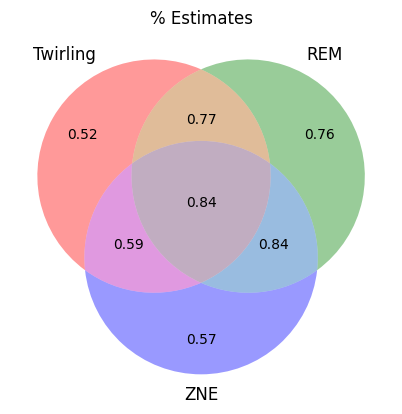

In [ ]:
try:
    from matplotlib_venn import venn3
    
    plt.title(r"% Estimates")
    venn3(
        subsets = [1 + 0.001*k for k in range(7)],
        set_labels= ("Twirling", "REM", "ZNE"),
        subset_label_formatter= func_mean,)
except ImportError:
    print("matplotlib_venn not installed, skipping plot")


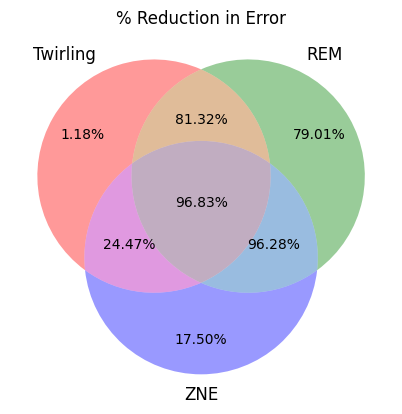

In [ ]:
try:
    from matplotlib_venn import venn3
    
    plt.title(r"% Reduction in Error")
    venn3(
        subsets = [1 + 0.001*k for k in range(7)],
        set_labels= ("Twirling", "REM", "ZNE"),
        subset_label_formatter= func_reduct,)
except ImportError:
    print("matplotlib_venn not installed, skipping plot")


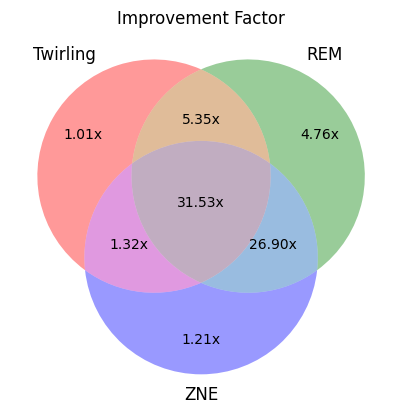

In [ ]:
try:
    from matplotlib_venn import venn3

    plt.title(r"Improvement Factor")
    venn3(
        subsets = [1 + 0.001*k for k in range(7)],
        set_labels= ("Twirling", "REM", "ZNE"),
        subset_label_formatter= func_improv)
except ImportError:
    print("matplotlib_venn not installed, skipping plot")

Another visualization can be seen by plotting the jackknife estimates, which should give an estimate of the mean and variance of our sample:

In [ ]:
em_mu,em_sig = jackknife_bias_corrected(cobs, zne_processor, axis=1)

noisy_mu,noisy_sig = jackknife_bias_corrected(cobs_00, zne_free_processor, axis=1)

# Generate x values for smooth normal curves
x_range = np.linspace(0.4, 1.0, 250)

# Calculate normalized normal distributions (these are already probability densities)
em_normal = np.exp(-0.5 * ((x_range - em_mu) / em_sig)**2) / (em_sig * np.sqrt(2*np.pi))
noisy_normal = np.exp(-0.5 * ((x_range - noisy_mu) / noisy_sig)**2) / (noisy_sig * np.sqrt(2*np.pi))
ideal_normal = np.exp(-0.5 * ((x_range - ideal_ev) / (1/np.sqrt(shots_per_obs)))**2) / ((1/np.sqrt(shots_per_obs)) * np.sqrt(2*np.pi))
plt.vlines([em_mu,noisy_mu,ideal_ev],0,27,colors=['purple','green','k'],alpha=0.5,linestyle='dashed')

# Plot normal distribution overlays
plt.plot(x_range, em_normal, 'purple', linestyle='--', linewidth=2, label = "EM")
plt.plot(x_range, noisy_normal, 'green', linestyle='dotted', linewidth=2, label = "Noisy")
plt.plot(x_range, ideal_normal, 'k', linestyle='-', linewidth=1, label='Ideal')
plt.legend()
# plt.vlines(ideal_ev, 0, max(max(em_normal), max(noisy_normal)), color='red', linestyle='-', label='Ideal')
plt.xlabel("Expectation Values")
plt.ylabel("Probability Density")
plt.show()



In [42]:
print(f"Total cost of this example: ${tracker.qpu_tasks_cost():.2f}")


Total cost of this example: $18.90


Here, the improvement in accuracy is quite drastic, as despite having many qubits, our circuit is not that deep, and we have optimized considerably to get a good result. 

For this precision, assuming that our method is more or less unbiased and that the true noisy mean is 0.52, we would expect to see improvements of between 14-16x improvement, maybe as low as 5-10x, solely based on precision, so our result is optimistically better. 

Regardless, with careful planning, these principles can be applied to numerous systems. For this workflow, we can see that individually, the different error mitigation methods do help, but not in as complete a manner as using them all together. 

### Conclusion

In this notebook we performed an advanced error mitigation workflow for a simple, but scalable problem using readout error mitigation, Pauli twirling for native gates, and zero-noise extrapolation. Our simulation was also aided in efficiency by several smaller optimizations, helping to improve the workflow.  

### References

- Arrasmith et al., Operator Sampling for Shot-frugal Optimization in Variational Algorithms (2020) [arXiv: 2004.06252](https://arxiv.org/pdf/2004.06252)
- Qiskit VF2 Layout, [Qiskit Documentation](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.passes.VF2Layout), Accessed Dec 30, 2025. 